In [ ]:
#!pip install pandas
#!pip install tensorflow
#!pip install numpy
#!pip install sklearn
#!pip install IPython
#!pip install matplotlib
#!pip install visualkeras
#!pip install itertools
#!pip install io
#!pip install datetime 
#!pip install mediapipe

## Librerías utilizadas

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from visualkeras import layered_view
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import visualkeras
import itertools
import io
import datetime 
import mediapipe as mp
import cv2



## Definiendo etiquetas

In [2]:
class_names= ["Apuntando","Caminando","Girando","Mano_A_Cabeza"] #Tambaleo_Lateral
categorical_enconded = tf.keras.utils.to_categorical([0,1,2,3],4)
categorical_enconded

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Función para cargar los datos desde un directorio

In [3]:
def load_data(data_dir):
    class_dirs = os.listdir(data_dir)
    num_classes = len(class_dirs)
    
    categorical_classes = tf.keras.utils.to_categorical([x for x in range(len(class_dirs))], num_classes)

    class_mapping = {class_name: categorical_classes[idx] for idx, class_name in enumerate(class_dirs)} 

    data = []
    labels = []
    
    for class_name in class_dirs:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        class_label = class_mapping[class_name]
        
        for file_name in os.listdir(class_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_path, file_name)
                df = pd.read_csv(file_path, header=0)
                class_data = np.array(df.iloc[:,1:].values.astype("float32"))
                
                data.append(np.asarray(class_data))
                labels.append(np.asarray(class_label))
    
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels, num_classes

# Load data
data_dir = 'Gestos_4_49'
data, labels, num_classes = load_data(data_dir)

# Split data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)


print("Number of classes:", num_classes)
#print("Labels: ",labels)
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Number of classes: 4
Shape of x_train: (168, 30, 99)
Shape of y_train: (168, 4)
Shape of x_test: (19, 30, 99)
Shape of y_test: (19, 4)


## Arquitectura del modelo

In [4]:
def get_model(input_shape, num_classes):
    model = Sequential([
        layers.InputLayer(input_shape=input_shape, name='Input'),
        # LSTM layers
        layers.Bidirectional(LSTM(50, return_sequences=True, name="1_LSTM",dropout=0.4)),
        layers.Bidirectional(LSTM(50, return_sequences=False, name="2_LSTM",dropout=0.4)),
        # Dense layer
        Dense(50, activation='relu'),
        Dropout(0.5),
        # Classification layer
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid', name='OUTPUT')
    ], name='LSTM_POSE_MODEL')
    
    return model
#Creating the model
input_shape = (x_train.shape[1],x_train.shape[2])
model = get_model(input_shape, num_classes=num_classes)
model.summary()

Model: "LSTM_POSE_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 100)          60000     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 OUTPUT (Dense)              (None, 4)                 204       
                                                                 
Total params: 125,654
Trainable params: 125,654
Non

## Compilando el modelo

In [5]:
#Compiling the model
model.compile(loss= losses.CategoricalCrossentropy(),
              #optimizer=optimizers.RMSprop(),
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy']
             )


## Funciones para la matriz de confusion

In [6]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image


figure = None
def log_confusion_matrix(epoch, logs):
    global figure
    test_pred_raw = model.predict(x_test)
    test_pred = np.argmax(test_pred_raw, axis=1)
    cm = confusion_matrix(y_test.argmax(axis=1), test_pred)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    # Para ver la matriz en tiempo real
    #clear_output(wait=True)
    #display(figure)
    with file_writer_cm.as_default():
        tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)
        
# Creating a file writer for confusion matrix logs
log_dir_cm = "./confusion_matrix_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(log_dir_cm)


## Entrenando el modelo

In [7]:
#Training the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./Pose_Recognition_Model/Pose_Recognition_LSTM.h5',
                             save_freq='epoch',
                             #save_weights_only=True,
                             save_best_only=True,
                             #monitor="val_accuracy",val_loss
                             monitor="val_accuracy",)


cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

epochs=50
batch_size = 32
history = model.fit(x_train,y_train,
                    epochs=epochs,
                    validation_data=(x_test,y_test),
                    callbacks=[ early_stopping, checkpoint,cm_callback],
                    verbose=1,
                    batch_size= batch_size
                   )

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/50
6/6 [==============================] - 17s 1s/step - loss: 1.3405 - accuracy: 0.3571 - val_loss: 1.2938 - val_accuracy: 0.2105
Epoch 2/50
6/6 [==============================] - 1s 203ms/step - loss: 1.2314 - accuracy: 0.4345 - val_loss: 1.1741 - val_accuracy: 0.5789
Epoch 3/50
6/6 [==============================] - 2s 290ms/step - loss: 1.1820 - accuracy: 0.4940 - val_loss: 1.1156 - val_accuracy: 0.5789
Epoch 4/50
6/6 [==============================] - 1s 261ms/step - loss: 1.1378 - accuracy: 0.5298 - val_loss: 0.9612 - val_accuracy: 0.6316
Epoch 5/50
6/6 [==============================] - 1s 259ms/step - loss: 1.0509 - accuracy: 0.5595 - val_loss: 0.7724 - val_accuracy: 0.7368
Epoch 6/50
6/6 [==============================] - 1s 275ms/step - loss: 1.0033 - accuracy: 0.5833 - val_loss: 0.6241 - val_accuracy: 0.7895
Epoch 7/50
6/6 [==============================] - 1s 237ms/step - loss: 0.9205 - accuracy: 0.6131 - val_loss: 0.5631 - val_accuracy: 0.7895
Epoch 8/50
6/6 [======

6/6 [==============================] - 1s 182ms/step - loss: 0.3052 - accuracy: 0.9167 - val_loss: 0.1259 - val_accuracy: 0.9474
Epoch 39/50
6/6 [==============================] - 1s 184ms/step - loss: 0.3006 - accuracy: 0.9167 - val_loss: 0.3001 - val_accuracy: 0.8947
Epoch 40/50
6/6 [==============================] - 1s 192ms/step - loss: 0.2958 - accuracy: 0.8869 - val_loss: 0.2535 - val_accuracy: 0.8947
Epoch 41/50
6/6 [==============================] - 1s 219ms/step - loss: 0.3480 - accuracy: 0.8690 - val_loss: 0.0720 - val_accuracy: 1.0000
Epoch 42/50
6/6 [==============================] - 1s 175ms/step - loss: 0.2576 - accuracy: 0.8988 - val_loss: 0.1300 - val_accuracy: 0.9474
Epoch 43/50
6/6 [==============================] - 1s 168ms/step - loss: 0.3479 - accuracy: 0.8869 - val_loss: 0.1232 - val_accuracy: 0.9474
Epoch 44/50
6/6 [==============================] - 1s 163ms/step - loss: 0.3125 - accuracy: 0.8869 - val_loss: 0.2430 - val_accuracy: 0.8947
Epoch 45/50
6/6 [========

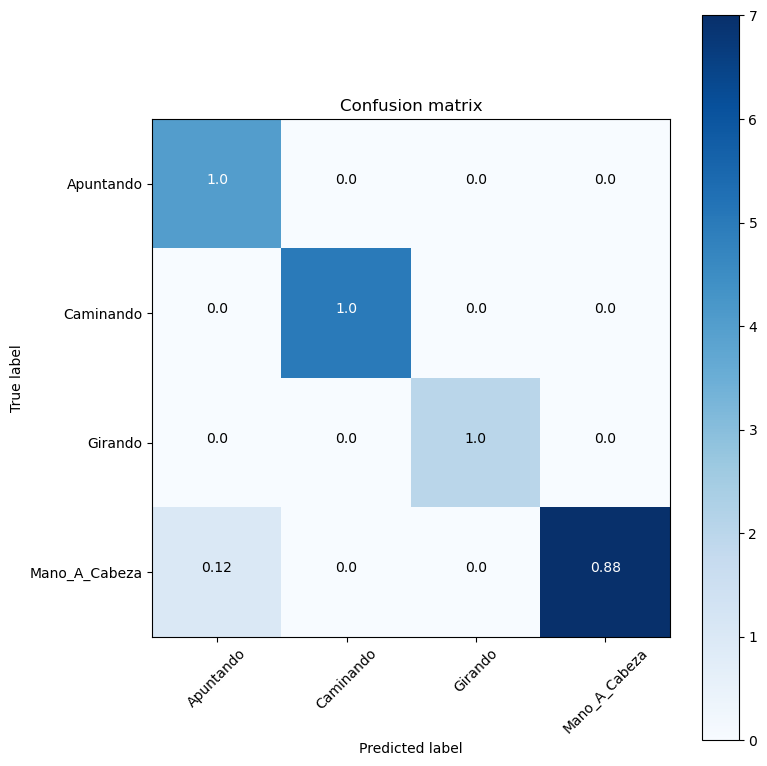

In [8]:
display(figure) #muestra la matriz de confusión

## Gráficas del loss y accuracy

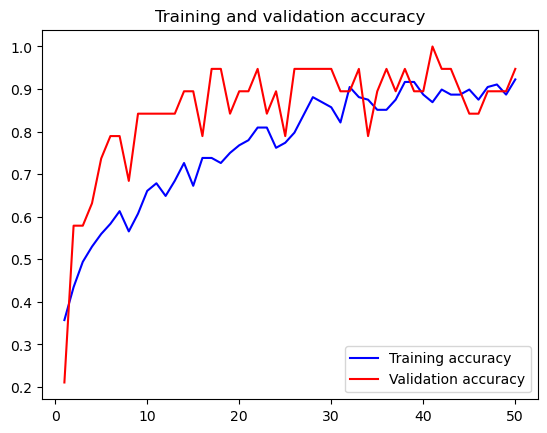

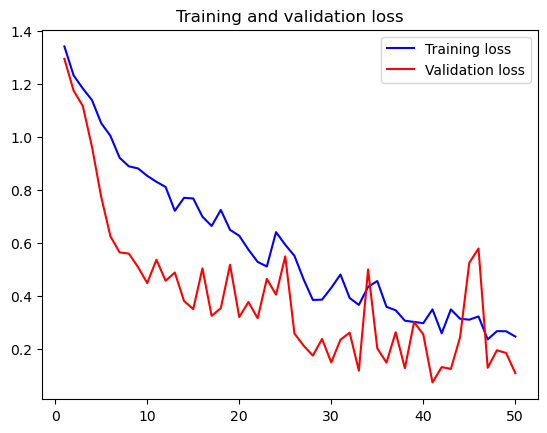

In [9]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "b", label="Training accuracy")
plt.plot(epochs, val_acc, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Guardando el mejor modelo

In [10]:
test_model = tf.keras.models.load_model("Pose_Recognition_Model\Pose_Recognition_LSTM.h5")
#predictions_values=test_model.predict(x_test)
#predictions=predictions_values.argmax(axis=1)

## Probando el modelo con los videos de 5 min

In [14]:

model = tf.keras.models.load_model('./Pose_Recognition_Model/Pose_Recognition_LSTM.h5')

test_data_dir = 'archivos_prueba'
batch_size = 30
overlap = 15  #solapamiento
prediction_threshold_apuntando_caminando = 0.98  # Umbral de predicción para las acciones de apuntar y caminar
prediction_threshold_mano_a_cabeza = 0.51  # Umbral de predicción para mano en la cabeza
prediction_threshold_girando = 0.95  # Umbral de predicción

def load_and_process_csv(file_path):
    df = pd.read_csv(file_path, header=0)
    class_data = np.array(df.iloc[:, 1:].values.astype("float32"))
    return class_data

        
def predicting_video(csv_path):
    count_class_name = {class_name: 0 for class_name in class_names}
    class_data = load_and_process_csv(csv_path)
    num_frames = len(class_data)
    
    for start in range(0, num_frames - batch_size + 1, batch_size - overlap):
        end = start + batch_size
        if end > num_frames: #para que deje de probar cuando no hayan más frames
            break
       
        batch_frames = class_data[start:end]
        batch_frames = np.expand_dims(batch_frames, axis=0)  # Agregar dimensión de lote
        predictions = model.predict(batch_frames)
        
        # Obtener la clase predicha y su probabilidad más alta
        predicted_class_idx = np.argmax(predictions)
        max_probability = np.max(predictions)
        
        predicted_class_name = class_names[predicted_class_idx]
        
        # Verificar si la probabilidad supera el umbral
   
        if predicted_class_name == "Apuntando" or predicted_class_name == "Caminando":
            if max_probability >= prediction_threshold_apuntando_caminando:
                print(f"Predicted class for frames {start}-{end}: {predicted_class_name} (Probability: {max_probability:.2f})")
                count_class_name[predicted_class_name] += 1
            
        elif predicted_class_name == "Mano_A_Cabeza":
            if max_probability >= prediction_threshold_mano_a_cabeza:
                print(f"Predicted class for frames {start}-{end}: {predicted_class_name} (Probability: {max_probability:.2f})")
                count_class_name[predicted_class_name] += 1
        
        elif predicted_class_name == "Girando":
            if max_probability >= prediction_threshold_girando:
                print(f"Predicted class for frames {start}-{end}: {predicted_class_name} (Probability: {max_probability:.2f})")
                count_class_name[predicted_class_name] += 1
            

        
test_data_dir = 'archivos_prueba'
csv_file = '2_53..csv'
csv_path = os.path.join(test_data_dir, csv_file)


predicting_video(csv_path)
    
    
#Predecir videos de un directorio 
#csv_files_path = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir) if f.endswith('.csv')]
#for csv_path in csv_files_path:
#    predicting_video(csv_path) 





1/1 [==============================] - 0s 45ms/step


## Probando en tiempo real con Mediapipe

In [ ]:
# Configuración de Mediapipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
holistic = mp_holistic.Holistic()

# Configuración de la cámara
cap = cv2.VideoCapture(0)  # Usar la cámara por defecto

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detección de puntos clave con Mediapipe
    results = holistic.process(frame)
    keypoints = results.pose_landmarks  # Obtener los puntos clave de poses
    
    #if keypoints is not None:
        # Procesar y formatear los datos de los puntos clave
        # Aquí necesitarás ajustar cómo extraer y formatear los datos específicos que necesitas
        
        # Realizar inferencias con tu modelo
        # predictions = model.predict(formatted_data)q
        
        # Aplicar umbral a las predicciones
        # if np.max(predictions) >= prediction_threshold:
        #     predicted_class_idx = np.argmax(predictions)
        #     predicted_class_name = class_names[predicted_class_idx]
        #     print(f"Predicted class: {predicted_class_name}")
        # else:
        #     print("No confident prediction")
    
    # Mostrar la imagen con anotaciones de Mediapipe
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('Pose Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()